In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.linalg

In [2]:
c = 10
m1 = 5
m2 = 3

T = 0.1

In [3]:
A = np.array([[0, -1/m1*c, 0, 1/m1*c],
             [1, 0, 0, 0],
             [0, 1/m2*c, 0, -1/m2*c],
             [0, 0, 1, 0]])

B = np.array([[1/m1],[0],[0],[0]])

In [4]:
A

array([[ 0.        , -2.        ,  0.        ,  2.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  3.33333333,  0.        , -3.33333333],
       [ 0.        ,  0.        ,  1.        ,  0.        ]])

In [5]:
B

array([[0.2],
       [0. ],
       [0. ],
       [0. ]])

In [6]:
blocked = np.zeros((5, 5))
blocked[:4, :4] = A
blocked[:4, 4:] = B

In [7]:
blocked

array([[ 0.        , -2.        ,  0.        ,  2.        ,  0.2       ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  3.33333333,  0.        , -3.33333333,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [8]:
exp_blocked = scipy.linalg.expm(blocked*T)

Ad = exp_blocked[:4, :4]
Bd = exp_blocked[:4, 4:]

In [9]:
steps = 400

F = np.sin(np.linspace(0, 10, steps))

In [10]:
x0 = np.zeros((4, 1))

In [11]:
X = np.zeros((4, steps+1))

In [12]:
for i in range(steps):
    X[:, i+1] = (Ad@X[:, i].reshape((4,1)) + (Bd*F[i])).flatten()

In [13]:
Ad@X[:, i].reshape((4,1)) + (Bd*F[i])

array([[ 0.91227964],
       [21.02096338],
       [ 0.91630401],
       [21.03822968]])

In [14]:
(Bd * F[i])

array([[-1.08442507e-02],
       [-5.43116019e-04],
       [-6.02858032e-05],
       [-1.50848579e-06]])

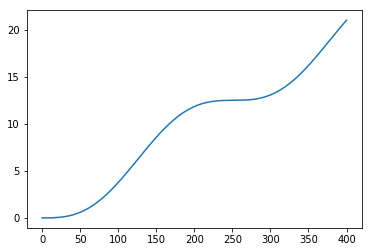

In [15]:
plt.plot(X[1, :])
plt.show()

In [76]:
import cvxpy as cvx

In [77]:
slack = cvx.Variable(1)

In [78]:
states = []
for i in range(steps+1):
    states.append(cvx.Variable(4))

In [79]:
forces = []
for i in range(steps):
    forces.append(cvx.Variable(1))

In [80]:
constraints = []

In [81]:
# starting state as constraint
starting_state = np.array([0, 1, 0, 1])

constraints.append(states[0] == starting_state)

In [82]:
# state transitions as constraint
for i in range(steps):
    constraints.append(states[i+1] == Ad*states[i] + Bd*forces[i])

In [92]:
states[0][1]

Expression(AFFINE, UNKNOWN, (1, 1))

In [93]:
# positions never below 0
for state in states:
    constraints.append(states[0][1] > 0)
    constraints.append(states[0][3] > 0)

In [94]:
state_norms = [cvx.norm(state, 2) for state in states]
force_norms = [cvx.norm(force, 2) for force in forces]

objective = cvx.Minimize(sum(state_norms) + sum(force_norms))

In [95]:
prob = cvx.Problem(objective, constraints)

In [96]:
prob.solve()

74.31671866916801

In [97]:
prob.status

'optimal'

In [98]:
states[0].value

matrix([[-2.04442525e-13],
        [ 1.00000000e+00],
        [-3.10080832e-12],
        [ 1.00000000e+00]])

In [99]:
states_num = [state.value for state in states]
states_num = np.array(states_num).reshape((-1, 4))

forces_num = [force.value for force in forces]
forces_num = np.array(forces_num)

In [100]:
states_num.shape

(401, 4)

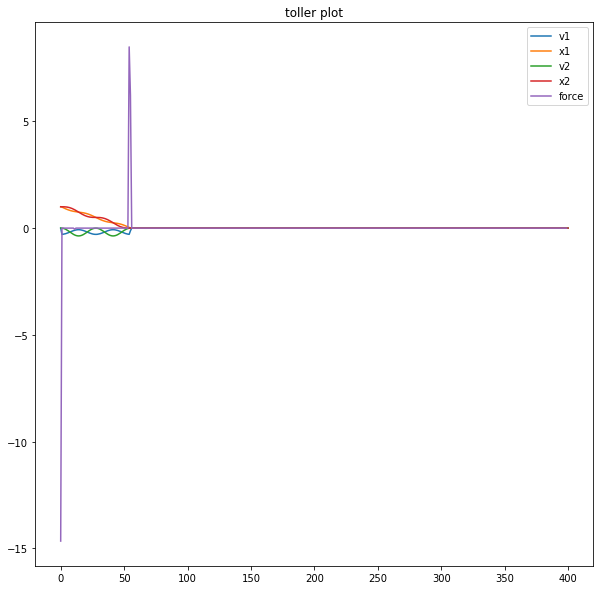

In [101]:
plt.figure(figsize=(10,10))
plt.title("toller plot")
plt.plot(states_num)
plt.plot(forces_num)
plt.legend(["v1", "x1", "v2", "x2", "force"])
plt.show()